# EDA on MediaEval Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## EDA on Devset

In [2]:
df = pd.read_pickle('dev.pkl')

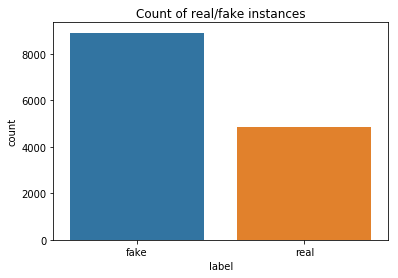

In [3]:
plt.title('Count of real/fake instances')
sns.countplot(x = 'label', data = df)
plt.xticks([0, 1], ['fake', 'real'])
plt.show()

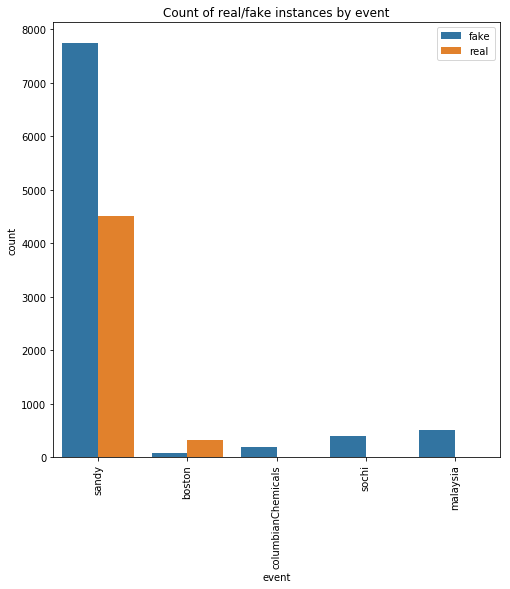

In [4]:
plt.figure(figsize = (8, 8))
plt.title('Count of real/fake instances by event')
sns.countplot(x = 'event', hue = 'label',data = df)
plt.xticks(rotation = 90)
plt.legend(['fake', 'real'], loc = 1)
plt.show()

'\nFrom "Prominent Features of Rumour Propogation in Online Social Media" IEEE on Data Mining, 2013\nThe author show the use of SpikeM time-series model for early detection of the rumour. They show rumour\ncan be characterized by sudden sharp peak as they hypothesize that rumour has short attention window\n'

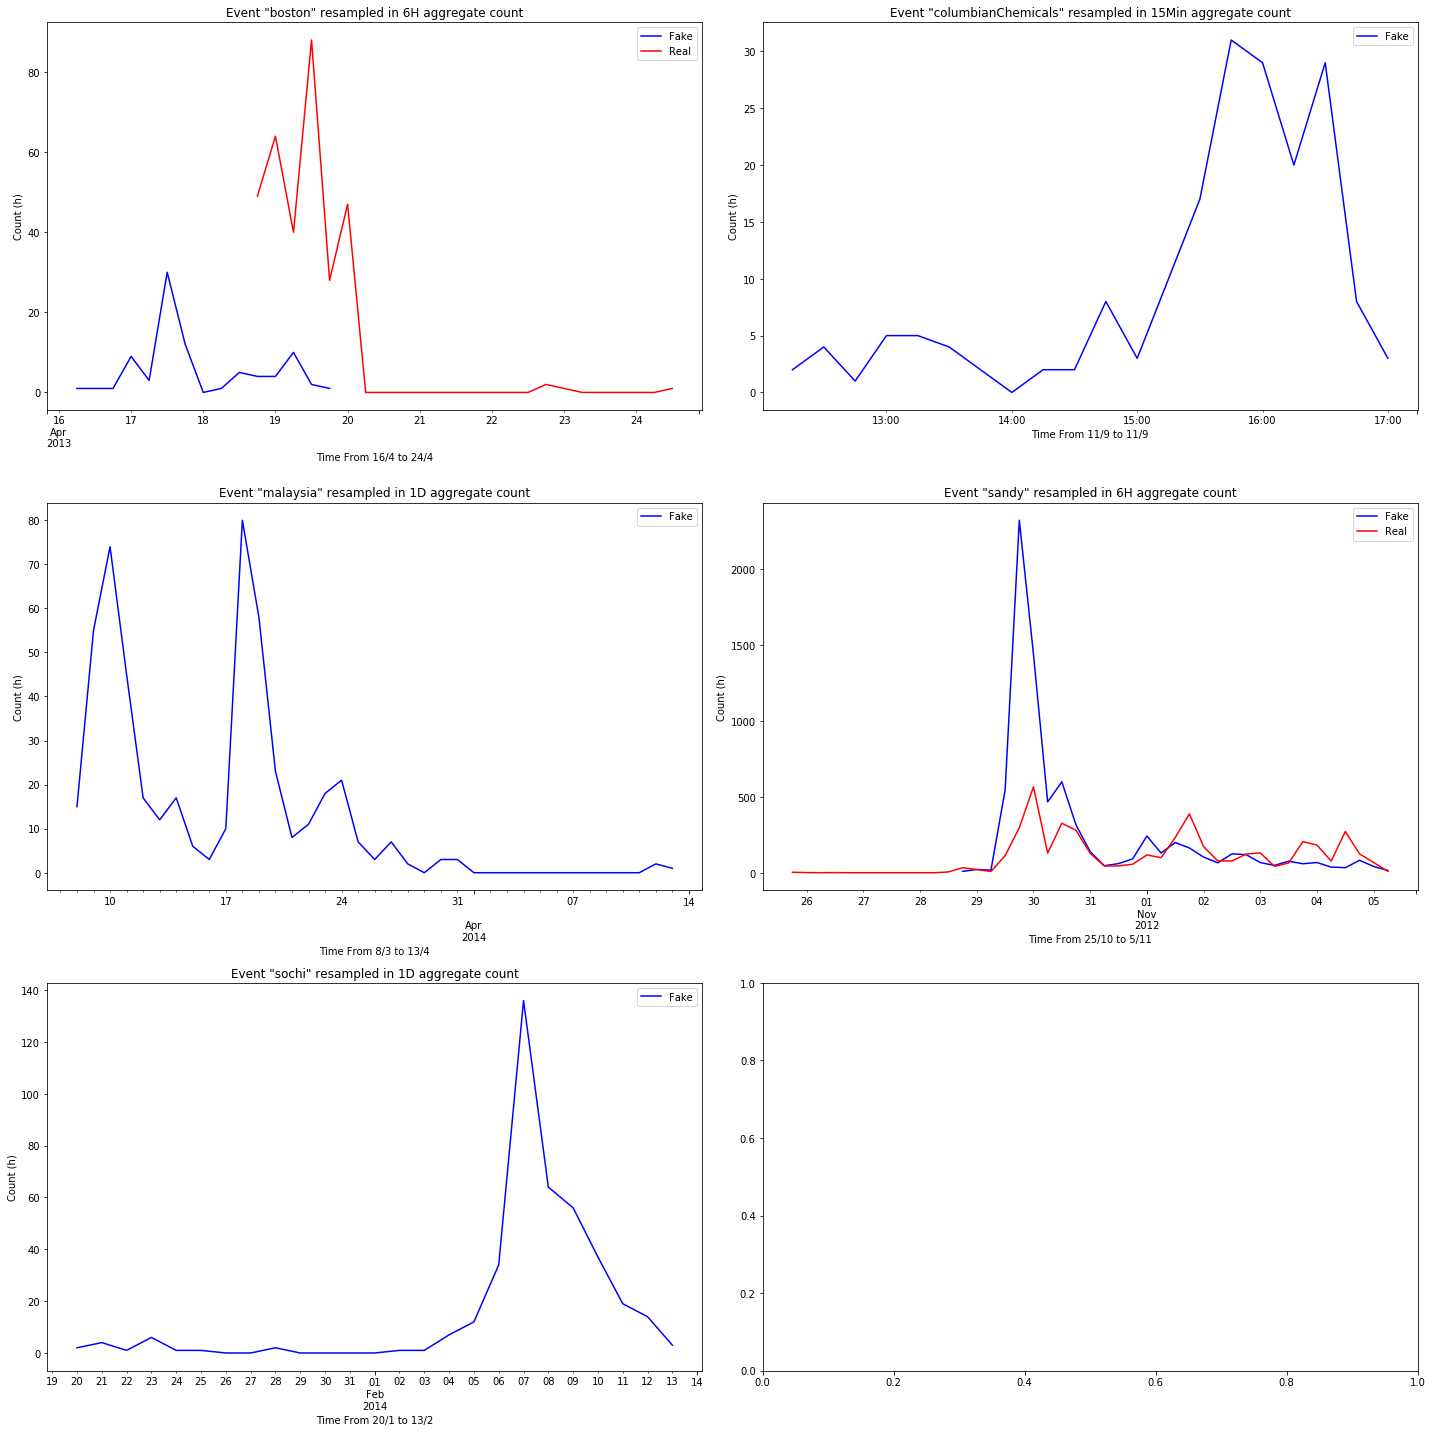

In [5]:
# Can skip

event_group = df.groupby('event')
event_group_size = event_group.size().size
event_group_nrow = int(np.ceil(event_group_size/2))

fig, ax = plt.subplots(nrows = event_group_nrow, ncols = 2, figsize = (20, 20))

for idx, (event, group) in enumerate(event_group):
    ncol = idx % 2
    nrow = idx // 2
    axs = ax[nrow, ncol]
    fake_group = group['label'] == 0
    real_group = group['label'] == 1
    
    time_diff = group.index.max() - group.index.min()
    
    if time_diff < pd.Timedelta('6 hours'):
        sampling = '15Min'
    elif time_diff < pd.Timedelta('3 days'):
        sampling = '1H'
    elif time_diff < pd.Timedelta('14 days'):
        sampling = '6H'
    else:
        sampling = '1D'
    group[fake_group].resample(sampling).count()['tweetText'].plot(ax = axs, color = 'blue', label = 'Fake')
    if (np.sum(real_group) > 0):
        group[real_group].resample(sampling).count()['tweetText'].plot(ax = axs, color = 'red', label = 'Real')
    axs.set_title('Event "{}" resampled in {} aggregate count'.format(event, sampling))
    first_occurence = group.index.min()
    last_occurence = group.index.max()
    axs.set_ylabel('Count (h)')
    axs.set_xlabel('Time From {}/{} to {}/{}'.format(first_occurence.day,\
                                                     first_occurence.month,\
                                                     last_occurence.day,\
                                                     last_occurence.month))
    axs.legend(loc = 1)
    
fig.tight_layout()

'''
From "Prominent Features of Rumour Propogation in Online Social Media" IEEE on Data Mining, 2013
The author show the use of SpikeM time-series model for early detection of the rumour. They show rumour
can be characterized by sudden sharp peak as they hypothesize that rumour has short attention window
'''

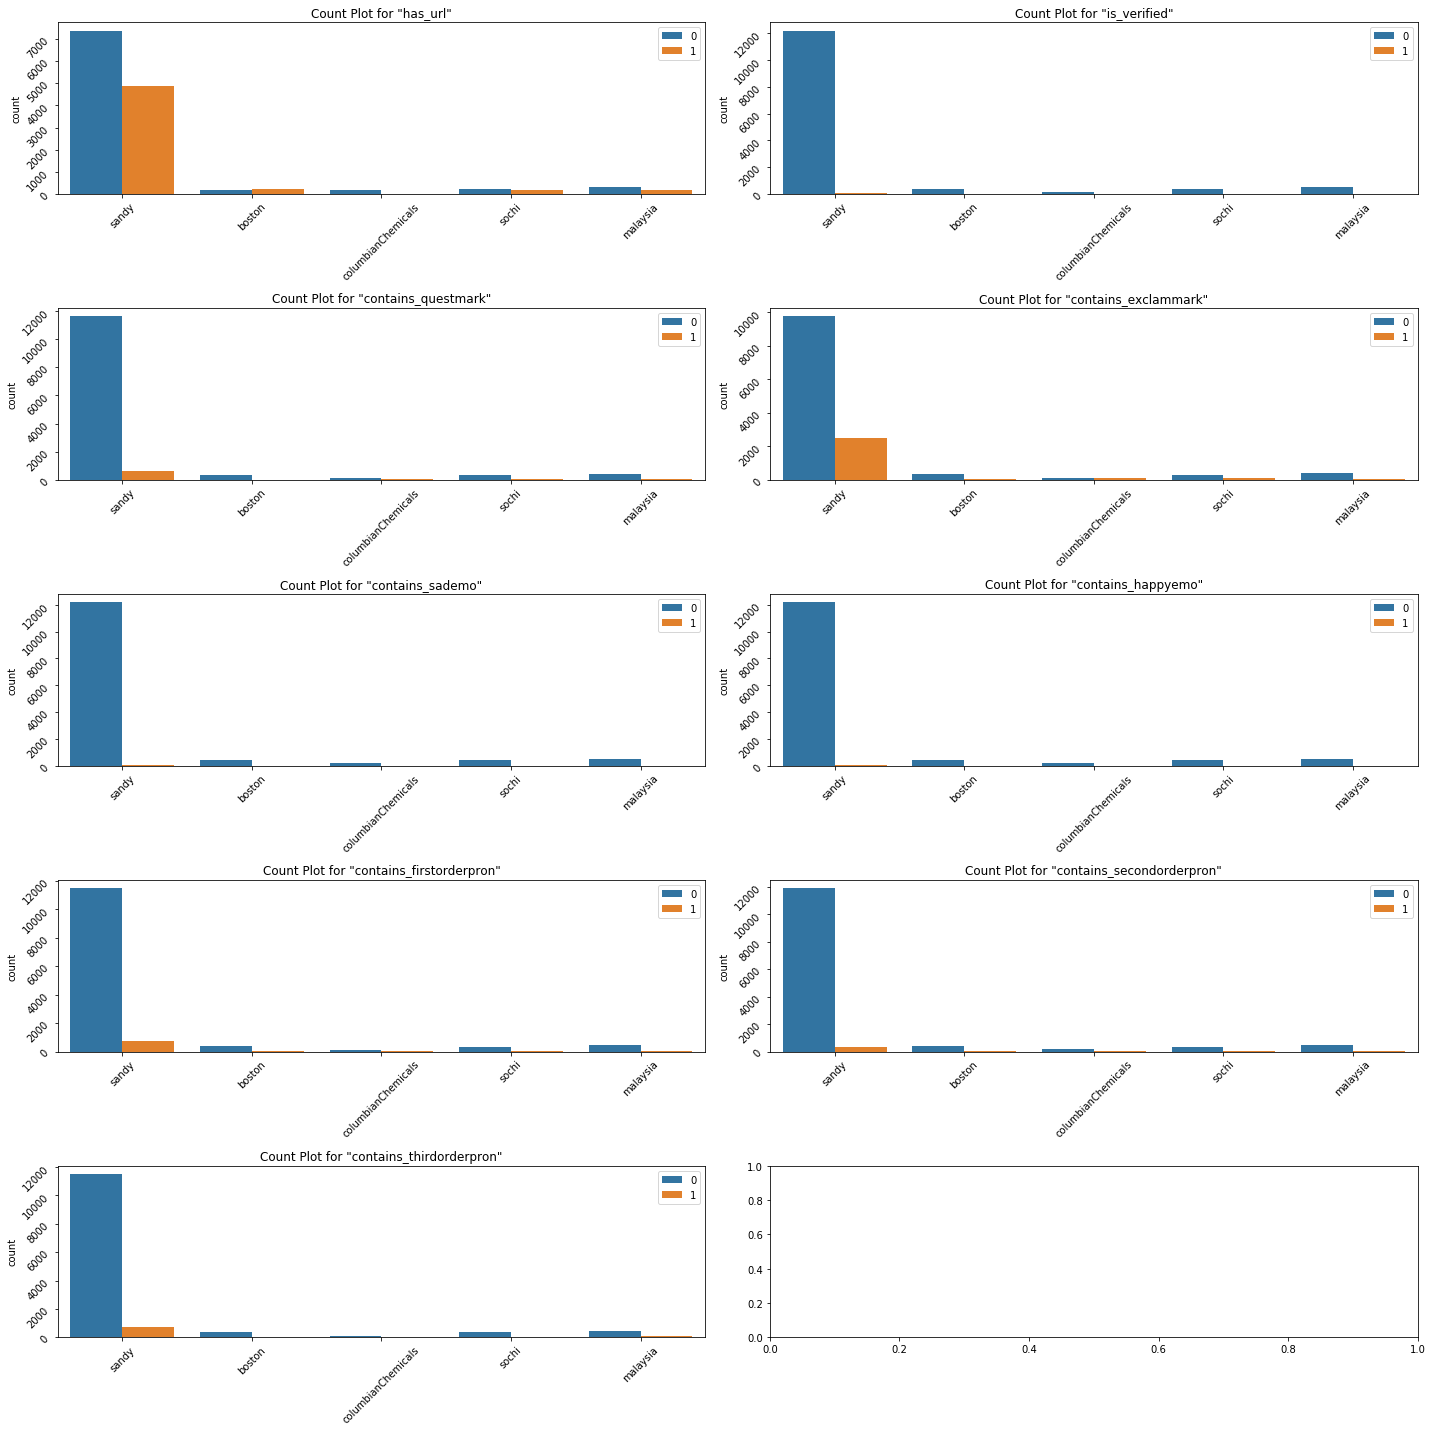

In [6]:
# Can skip

count_groups = ['has_url', 'is_verified', 'contains_questmark', 'contains_exclammark', 'contains_sademo', \
               'contains_happyemo', 'contains_firstorderpron', 'contains_secondorderpron', 'contains_thirdorderpron']
count_group_nrows = int(np.ceil(len(count_groups) / 2))

fig, ax = plt.subplots(nrows = count_group_nrows, ncols = 2, figsize = (20, 20))

for idx, cnt in enumerate(count_groups):
    ncol = idx % 2
    nrow = idx // 2
    countplot = sns.countplot(x = 'event', hue = cnt, data = df, ax = ax[nrow, ncol])
    countplot.tick_params(rotation = 45)
    countplot.set_title('Count Plot for "{}"'.format(cnt))
    countplot.legend(loc = 1)
    countplot.set_xlabel('')

fig.tight_layout()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


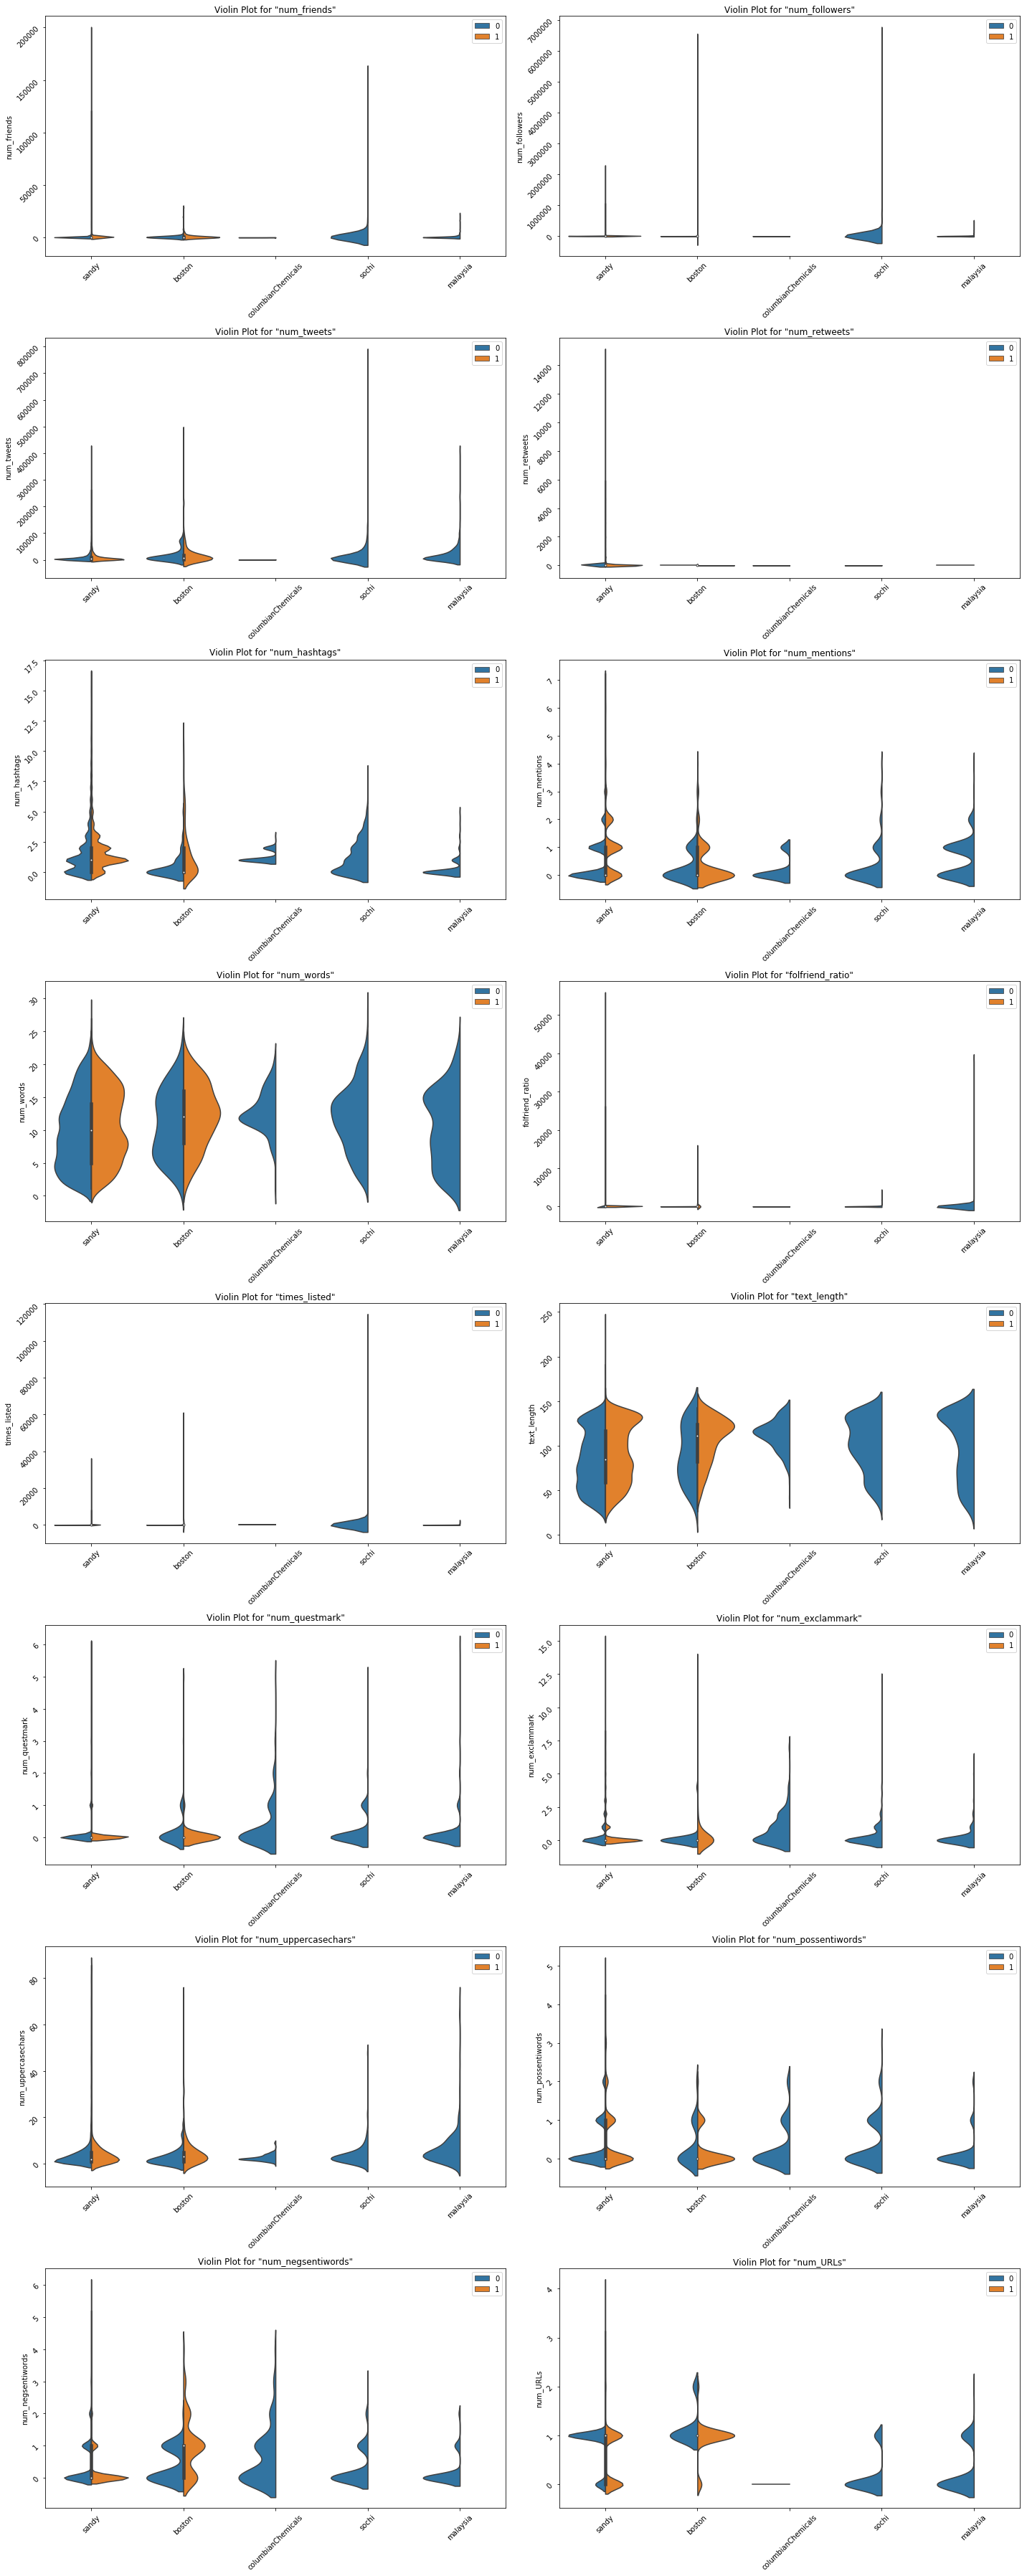

In [7]:
# Can skip

numerical_col = ['num_friends', 'num_followers', 'num_tweets', 'num_retweets', 'num_hashtags', 'num_mentions', \
                 'num_words', 'folfriend_ratio', 'times_listed', 'text_length', 'num_questmark', 'num_exclammark',\
                'num_uppercasechars', 'num_possentiwords', 'num_negsentiwords', 'num_URLs']

numerical_col_nrows = int(np.ceil(len(numerical_col) / 2))

fig, ax = plt.subplots(nrows = numerical_col_nrows, ncols = 2, figsize = (20, 50))

for idx, cnt in enumerate(numerical_col):
    ncol = idx % 2
    nrow = idx // 2
    violinplot = sns.violinplot(x = 'event', y = cnt, hue = 'label', \
               split = True, data = df, ax = ax[nrow, ncol])
    violinplot.tick_params(rotation = 45)
    violinplot.set_title('Violin Plot for "{}"'.format(cnt))
    violinplot.legend(loc = 1)
    violinplot.set_xlabel('')
    
fig.tight_layout()

In [8]:
import gensim, re
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

def tokenizeTweet(sent):
    # Remove http and punctations
    # Remove all stops words
    sent = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', sent)
    sent = re.sub(r"(?:\@|\#|rt)\S+", "", sent)
    sent = re.sub(r'[^a-z0-9\s]', '', sent)
    sent = sent.split()
    sent = [word for word in sent if word not in stopWords]
    sent = ' '.join(sent)
    
    return sent

df.loc[:, 'tweetText'] = df.loc[:, 'tweetText'].str.lower().apply(tokenizeTweet)

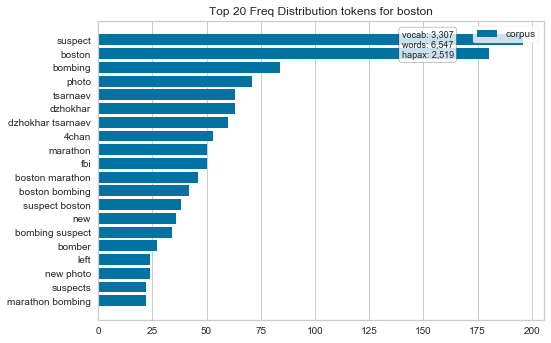

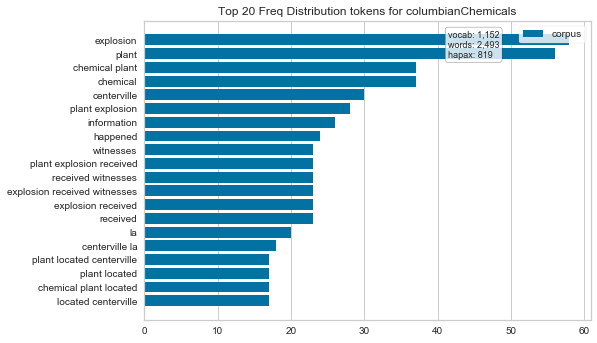

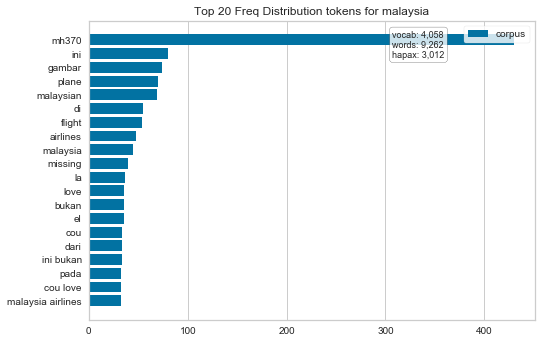

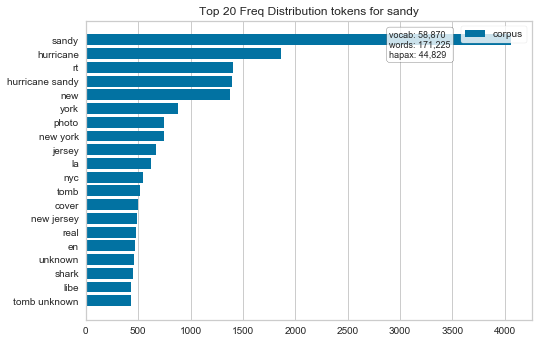

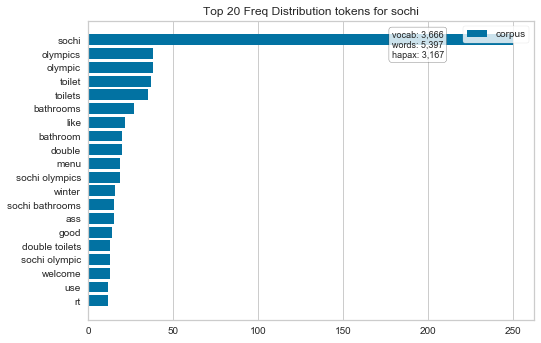

In [9]:
# Can skip

from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

for idx, (event, group) in enumerate(event_group):
    ncol = idx % 2
    nrow = idx // 2
    corpus = df.loc[df.loc[:, 'event'] == event, 'tweetText']
    try:
        vectorizer = CountVectorizer(stop_words = 'english', ngram_range = [1, 3])
        docs = vectorizer.fit_transform(corpus)
        features = vectorizer.get_feature_names()
        
        title = 'Top 20 Freq Distribution tokens for {}'.format(event)
        visualizer = FreqDistVisualizer(features = features, n = 20, title = title)
        visualizer.fit(docs)
        visualizer.poof()
    except:
        print('{} cannot be parsed'.format(event))